# **K-Nearest Neighbors (KNN) Algorithm Logic**
## **1. Initialization**
* **Define K**: Select the value for 'K', which represents the number of nearest neighbors to consider for classification.
* **Choose Metric**: Select a distance metric (e.g., Euclidean or Manhattan distance) to measure similarity between data points.
## **2. Training (The "Fit" Phase)**
* **Lazy Learning**: Unlike most models, KNN is a "Lazy Learner" that does not build a discriminative model.
* **Data Storage**: The training phase consists solely of storing the labeled numeric dataset as numerical feature vectors in memory.
## **3. Prediction (The "Inference" Phase)**
For every new sample in the **Fashion-MNIST** test set:
1. **Distance Calculation**: Compute the distance between the new sample and every single training sample.
2. **Sorting**: Sort all calculated distances in ascending order.
3. **Neighbor Selection**: Identify the top 'K' training samples with the smallest distances.
4. **Majority Voting**: Retrieve the labels of these 'K' neighbors.
5. **Final Assignment**: Assign the most frequent label (the mode) to the new sample.
## **4. Evaluation and Analysis**
* **Accuracy Assessment**: Compare the predicted labels against the actual labels of the test set to calculate overall model accuracy.
* **Misclassification Analysis**: Review the specific samples that were incorrectly labeled to identify patterns or similarities that confused the model.
* **Parameter Impact**: Explain how changing the value of 'K' or the distance metric influences the classification results.


In [60]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import os

In [61]:
class KNN:
    def __init__(self, k: int, dist_metric: str):
        self.k = k
        self.dist_metric = dist_metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _compute_distance(self, x1, x2):
        if self.dist_metric == 'euclidean':
            # L2 Norm: Standard straight-line distance
            return np.sqrt(np.sum((x1 - x2)**2))
        
        elif self.dist_metric == 'manhattan':
            # L1 Norm: "City block" distance (sum of absolute differences)
            return np.sum(np.abs(x1 - x2))
        
        elif self.dist_metric == 'chebyshev':
            # L-infinity Norm: Maximum absolute difference
            return np.max(np.abs(x1 - x2))
        
        else:
            raise ValueError(f"Unknown metric: {self.dist_metric}")

    def predict(self, X_test):
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

    def _predict_single(self, x):
        # 1. Compute distances between x and all examples in training set
        distances = [self._compute_distance(x, x_train) for x_train in self.X_train]

        # 2. Sort by distance and return indices of the first k neighbors 
        k_indices = np.argsort(distances)[:self.k]

        # 3. Extract the labels of the k nearest neighbor samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # 4. Majority vote: most common class label
        most_common = max(set(k_nearest_labels), key=k_nearest_labels.count)
        return most_common

In [62]:
def load_mnist_raw(path, kind='train'):
    """Load Fashion-MNIST data from binary files."""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        # Reshape to (number of samples, 784) to create feature vectors
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


In [63]:
# Load the data (assuming you used the load_mnist_raw function from earlier)
X_train_raw, y_train = load_mnist_raw('./KNN_from_scratch/data', kind='train')
X_test_raw, y_test = load_mnist_raw('./KNN_from_scratch/data', kind='t10k')

# Requirement: Represent samples as numerical feature vectors
# Flatten 28x28 images to 784-dimensional vectors and normalize
X_train = X_train_raw.reshape(-1, 784) / 255.0
X_test = X_test_raw.reshape(-1, 784) / 255.0

# Subsampling for speed
X_train_sub = X_train[:5000]
y_train_sub = y_train[:5000]
X_test_sub = X_test[:500]
y_test_sub = y_test[:500]

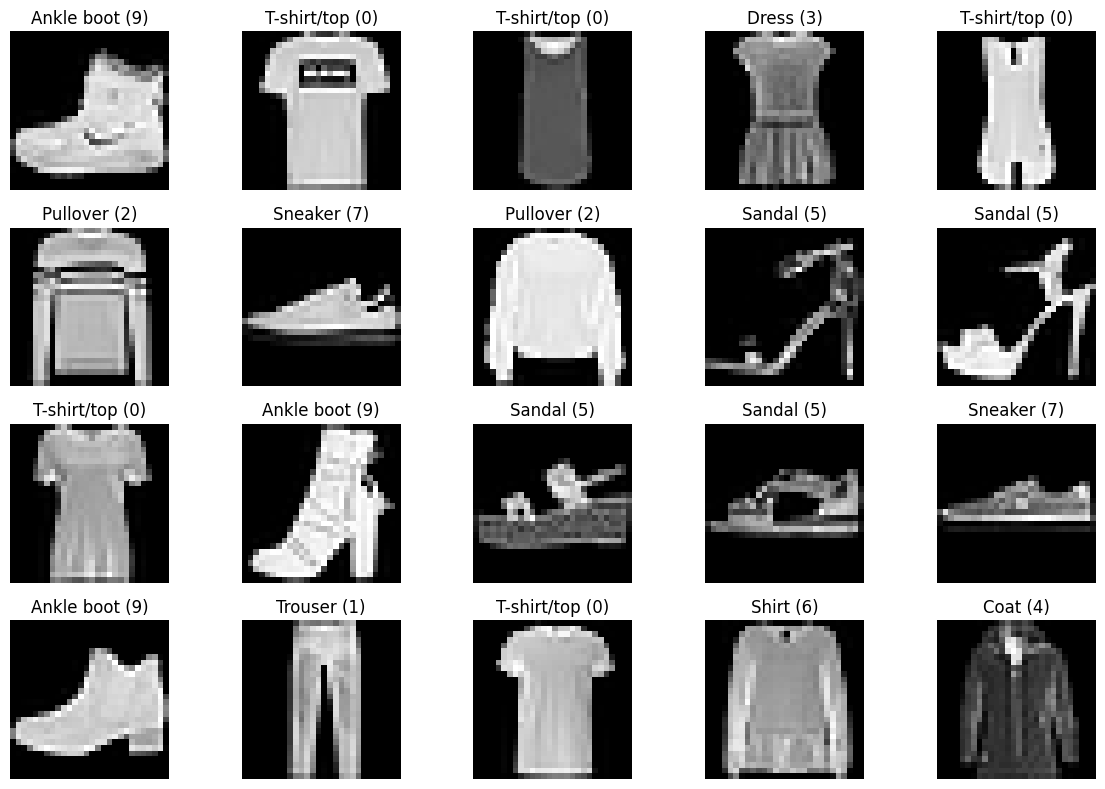

In [64]:
# Define the standard class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot images and its labels
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    # Reshape the flattened 784 vector back to 28x28 for display
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"{class_names[y_train[i]]} ({y_train[i]})")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [65]:
# Initialize with a chosen K value 
k_value = 4
dist_metric = 'chebyshev'  # Options: 'euclidean', 'manhattan', 'chebyshev'
knn_model = KNN(k=k_value, dist_metric=dist_metric)

# Fit the training data
knn_model.fit(X_train_sub, y_train_sub)

# Run predictions
y_pred = knn_model.predict(X_test_sub)

In [66]:
# Calculate accuracy
accuracy = np.sum(y_pred == y_test_sub) / len(y_test_sub)
print(f"Model Accuracy with K={k_value}: {accuracy * 100:.2f}%")

# Identifying misclassified samples for your report.txt 
misclassified_indices = np.where(y_pred != y_test_sub)[0]
print(f"Number of misclassified samples: {len(misclassified_indices)}")

Model Accuracy with K=4: 60.00%
Number of misclassified samples: 200


In [67]:
# 1. Use a subset of the Fashion-MNIST data for faster plotting
# X_train_fashion should be (samples, 784)
subset_size = 500
X_subset = X_train[:subset_size]
y_subset = y_train[:subset_size]

# 2. Reduce 784 pixels to 2 Principal Components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

# 3. Fit your custom KNN on the 2D data
knn_vis = KNN(k=k_value, dist_metric=dist_metric)
knn_vis.fit(X_pca, y_subset)

# 4. Create a dense grid (Meshgrid)
h = 0.5  # Step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 5, X_pca[:, 0].max() + 5
y_min, y_max = X_pca[:, 1].min() - 5, X_pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 5. Predict for every point in the 2D space
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = knn_vis.predict(grid_points)
Z = Z.reshape(xx.shape)

# 6. Plot the boundaries


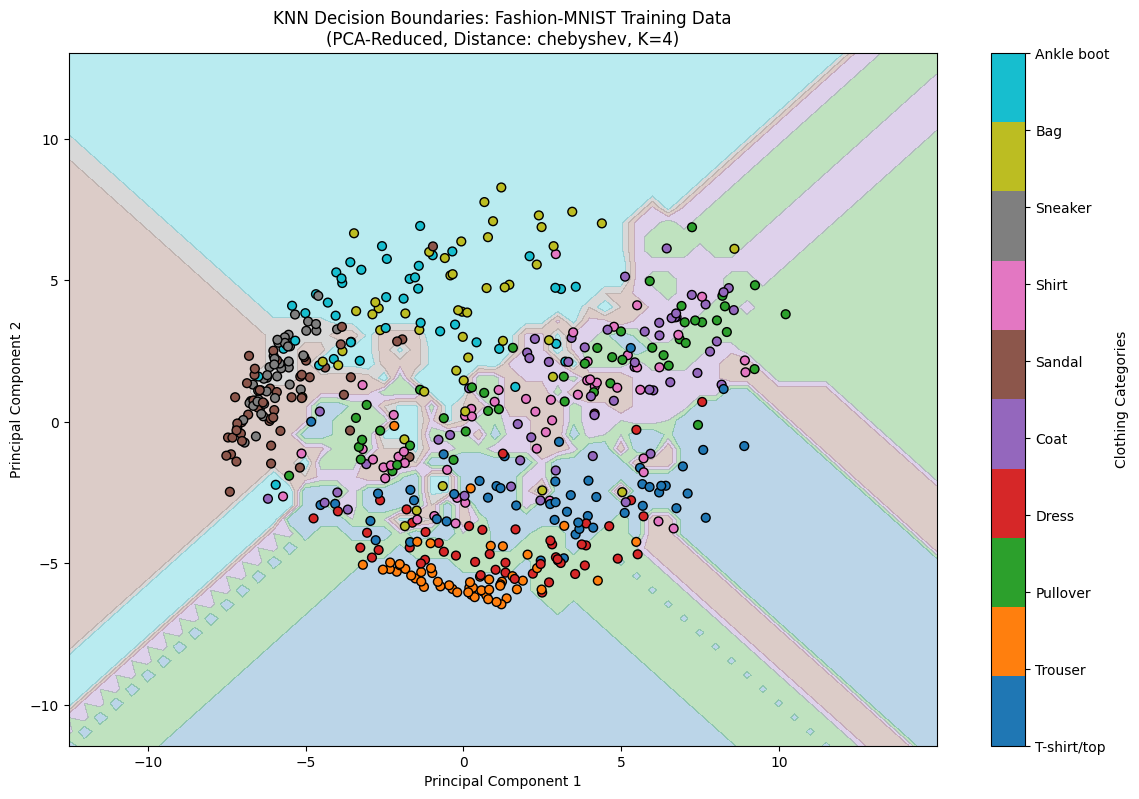

In [68]:
# 6. Plot the boundaries
plt.figure(figsize=(14, 9))

# Create the background regions
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10') 

# Create the scatter plot
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, edgecolors='k', s=40, cmap='tab10')

# Labeling
plt.title(f"KNN Decision Boundaries: Fashion-MNIST Training Data\n(PCA-Reduced, Distance: {dist_metric}, K={k_value})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# --- Colorbar Configuration ---
# 1. Define the Fashion-MNIST class labels
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# 2. Add the colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Clothing Categories')

# 3. Set the ticks to the center of each color segment (0 to 9)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(class_names)

plt.show()

In [ ]:
# 1. Transform a subset of Test Data using the SAME PCA object
test_subset_size = 100
X_test_subset = X_test[:test_subset_size]
y_test_subset = y_test[:test_subset_size]
X_test_pca = pca.transform(X_test_subset) # Important: use transform(), not fit_transform()

# 2. Plotting


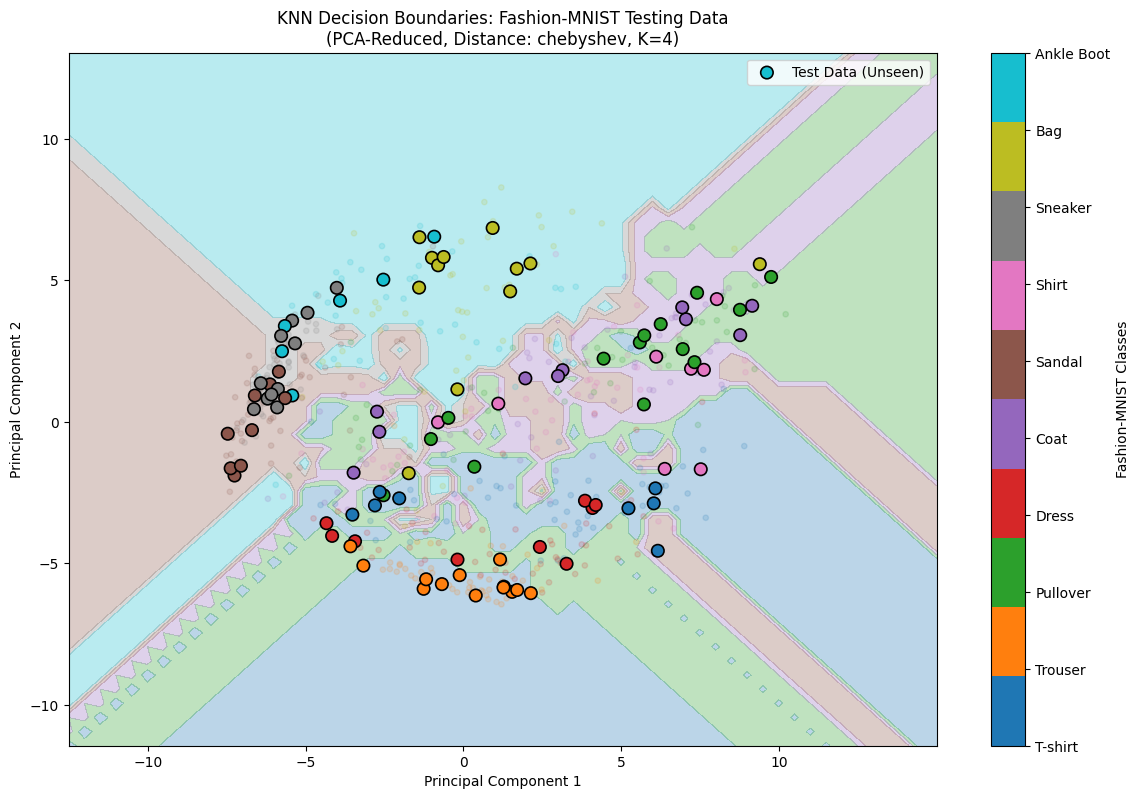

In [75]:
plt.figure(figsize=(14, 9))

# 1. Plot the decision regions
# Decision Regions (Stay the same, generated from Training data)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10') 

# 2. Plot Training data (Subtle dots)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, 
            alpha=0.15, s=15, cmap='tab10')

# 3. Plot Test data (High-contrast circles with black edges)
# We save this to 'sc' to act as the source for the colorbar
sc = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_subset, 
                marker='o', s=80, edgecolors='black', linewidths=1.2, 
                cmap='tab10', label='Test Data (Unseen)')

# 4. Add the colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Fashion-MNIST Classes')

# Define the category names for your report
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Set ticks to the middle of the color segments
cbar.set_ticks(np.linspace(0, 9, 10))
cbar.set_ticklabels(class_names)

plt.title(f"KNN Decision Boundaries: Fashion-MNIST Testing Data\n(PCA-Reduced, Distance: {dist_metric}, K={k_value})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc='upper right')
plt.show()